Here, we illustrate the application of the HME framework.

Before running this notebook, please ensure that you have completed the `Merge Model Weights` step in the README.md, along with all preceding steps.


Let's start with the **Property QA task**. First, load the model to one GPU. 

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from rdkit import Chem
from rdkit.Chem import Draw

# Import the custom classes from our package
from hme.modeling_llava import (
    HMEForConditionalGeneration,
    HMEForSequenceRegression,
    HMEForSequenceClassification,
    HMEConfig,
)
from hme.data import HMEProcessor,TrainHMECollator

# --- Configuration ---
MODEL_PATH = "../checkpoints/HME_property-qa-2_merged"
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

# --- Load Model Components ---
# 1. Load the base language model and tokenizer
language_model = AutoModelForCausalLM.from_pretrained(MODEL_PATH,torch_dtype=torch.bfloat16,attn_implementation="flash_attention_2").to(DEVICE)
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
tokenizer.padding_side = "left" # Important for generation

# 2. Create the full HME model architecture
config=HMEConfig(text_config=language_model.config,
                molecule_2d_hidden_size=300,
                molecule_3d_hidden_size=512,
                protein_hidden_size=128,
                ignore_index=-100,
                modal_padding=-100,
                projector_hidden_act="gelu",
                protein_token_index=tokenizer.convert_tokens_to_ids("<protein>"),
                molecule_2d_token_index=tokenizer.convert_tokens_to_ids("<molecule_2d>"),
                molecule_3d_token_index=tokenizer.convert_tokens_to_ids("<molecule_3d>"),
        )
model = HMEForConditionalGeneration(config, language_model)

# 3. Load our custom trained weights (the feature fuser)
feature_fuser_path = f"{MODEL_PATH}/feature_fuser.pth"
model.feature_fuser.load_state_dict(torch.load(feature_fuser_path, map_location=DEVICE))
model.to(DEVICE).eval().to(torch.bfloat16)

# 4. Create the HME Processor, Collator
processor = HMEProcessor(tokenizer=tokenizer, max_length=512)
data_collator = TrainHMECollator(processor=processor, config=config)

print(f"Model and tokenizer loaded successfully on {DEVICE}.")

You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

/tmp/ipykernel_349107/1716790332.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.feature_fuser.load_state_dict(torch.load(feature_fuser_path, map_location=DEVICE)

Model and tokenizer loaded successfully on cuda:0.


Load the dataset used for demonstration. Here we directly load the test set and use one sample as demonstration.



--- Loading Demo Data Sample ---


/home/lvliuzhenghao/llzh/HME/src/hme/data.py:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(emb_dict_mol, map_location="cpu")


Now the length of the dataset is 311868
Successfully loaded one sample for demonstration.
Molecule SMILES: C[C@@]12CC[C@H](O)C[C@H]1CC[C@@H]1[C@H]2CC[C@@]2(C)C(=O)CC[C@@H]12
2D Features Shape: torch.Size([1, 21, 300])
3D Features Shape: torch.Size([1, 51, 512])
Question: I need to know the HOMO of this molecule, could you please provide it? If uncertain, provide an estimate. Respond with the numerical value only.


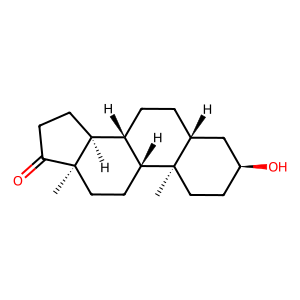

In [ ]:
from hme.data import HMEDataset
# --- Load Demo Data ---
TEST_DATA_JSON_PATH='../datasets/property_qa_test_2.json'
MOL_EMBEDDINGS_PT_PATH='../datasets/property_qa_test_2.json.cfm.pt'
print("\n--- Loading Demo Data Sample ---")

# We specify the task_type and data_type required by this sample
demo_dataset = HMEDataset(
    data_path=TEST_DATA_JSON_PATH,
    task_type='qa',
    data_type='1d,2d,3d,frg',  ##we use 1D,2D,3D,Fragment features as the multi-modal inputs
    emb_dict_mol=MOL_EMBEDDINGS_PT_PATH,
    emb_dict_protein='none'
)

# Fetch the first sample from the dataset
# This returns a list: [question, answer, 2d_features, 3d_features, protein_features]
data_sample = demo_dataset[0]
prompt_template, ground_truth_answer, mol_2d_features, mol_3d_features, _ = data_sample

# Prepare features for inference (add batch dimension and move to device)
mol_2d_features = mol_2d_features.unsqueeze(0).to(DEVICE)
mol_3d_features = mol_3d_features.unsqueeze(0).to(DEVICE)

# Get the SMILES string for visualization
smiles_for_demo = demo_dataset.json_list[0]['smiles']
mol_for_demo = Chem.MolFromSmiles(smiles_for_demo)

print("Successfully loaded one sample for demonstration.")
print(f"Molecule SMILES: {smiles_for_demo}")
print(f"2D Features Shape: {mol_2d_features.shape}")
print(f"3D Features Shape: {mol_3d_features.shape}")
print(f"Question: {demo_dataset.json_list[0]['instruction']}")
Draw.MolToImage(mol_for_demo)

Run the model, perform inference, and display the model's answer and Groud Truth.

If you want to get the full results on the test set, run our bash script in ./scripts/eval_property-qa-2.sh

In [ ]:
# The prompt comes directly from our loaded data sample
prompt_multi_modal = prompt_template
# Use the HMEProcessor to correctly combine text and modal features
inputs_multi_modal = processor(
    text=prompt_multi_modal,
    molecule_raw_2d_features=mol_2d_features,
    molecule_raw_3d_features=mol_3d_features,
    return_tensors="pt"
)

# Move the data from cpu to DEVICE
inputs_multi_modal = {
    k: v.to(DEVICE) if isinstance(v, torch.Tensor) else v
    for k, v in inputs_multi_modal.items()
}

# Generate a response
with torch.no_grad():
    output_ids_mm = model.generate(
        **inputs_multi_modal,
        max_new_tokens=100,
        do_sample=False,
        eos_token_id=tokenizer.eos_token_id,
    )

# Decode and print the response
response_ids_mm = output_ids_mm[:, inputs_multi_modal['input_ids'].shape[1]:]
response_text_mm = tokenizer.batch_decode(response_ids_mm, skip_special_tokens=True)[0]

print("--- Multi-Modal Prompt ---")
print(prompt_multi_modal)
print("\n--- Ground Truth Answer ---")
print(ground_truth_answer)
print("\n--- Model Response ---")
print(response_text_mm)

I need to know the HOMO of this molecule, could you please provide it? If uncertain, provide an estimate. Respond with the numerical value only. Molecular 2D features are: <molecule_2d><molecule_2d><molecule_2d><molecule_2d><molecule_2d><molecule_2d><molecule_2d><molecule_2d>. Molecular 3D features are: <molecule_3d><molecule_3d><molecule_3d><molecule_3d><molecule_3d><molecule_3d><molecule_3d><molecule_3d><molecule_3d><molecule_3d><molecule_3d><molecule_3d><molecule_3d><molecule_3d><molecule_3d><molecule_3d>. Molecular SMILES is: C[C@@]12CC[C@H](O)C[C@H]1CC[C@@H]1[C@H]2CC[C@@]2(C)C(=O)CC[C@@H]12. Molecular fragments are: <|CCCC=O|><|CCCCCCO|><|CCCCC|><|CCCC|>.


We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


--- Multi-Modal Prompt ---
I need to know the HOMO of this molecule, could you please provide it? If uncertain, provide an estimate. Respond with the numerical value only. Molecular 2D features are: <molecule_2d><molecule_2d><molecule_2d><molecule_2d><molecule_2d><molecule_2d><molecule_2d><molecule_2d>. Molecular 3D features are: <molecule_3d><molecule_3d><molecule_3d><molecule_3d><molecule_3d><molecule_3d><molecule_3d><molecule_3d><molecule_3d><molecule_3d><molecule_3d><molecule_3d><molecule_3d><molecule_3d><molecule_3d><molecule_3d>. Molecular SMILES is: C[C@@]12CC[C@H](O)C[C@H]1CC[C@@H]1[C@H]2CC[C@@]2(C)C(=O)CC[C@@H]12. Molecular fragments are: <|CCCC=O|><|CCCCCCO|><|CCCCC|><|CCCC|>.

--- Ground Truth Answer ---
The HOMO for the input molecule is -6.318 eV.

--- Model Response ---
 HOMO for the input molecule is -6.299 eV.


--------------------------------

Then, we proceed with the **General QA** task. 

Load the model. (You can restart this notebook before running the cell below to prevent memory overflow caused by the previous model still occupying GPU memory.)

In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from rdkit import Chem
from rdkit.Chem import Draw

# Import the custom classes from our package
from hme.modeling_llava import (
    HMEForConditionalGeneration,
    HMEForSequenceRegression,
    HMEForSequenceClassification,
    HMEConfig,
)
from hme.data import HMEProcessor,TrainHMECollator

# --- Configuration ---
MODEL_PATH = "../checkpoints/HME_general-qa_merged"
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

# --- Load Model Components ---
# 1. Load the base language model and tokenizer
language_model = AutoModelForCausalLM.from_pretrained(MODEL_PATH,torch_dtype=torch.bfloat16,attn_implementation="flash_attention_2").to(DEVICE)
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
tokenizer.padding_side = "left" # Important for generation

# 2. Create the full HME model architecture
config=HMEConfig(text_config=language_model.config,
                molecule_2d_hidden_size=300,
                molecule_3d_hidden_size=512,
                protein_hidden_size=128,
                ignore_index=-100,
                modal_padding=-100,
                projector_hidden_act="gelu",
                protein_token_index=tokenizer.convert_tokens_to_ids("<protein>"),
                molecule_2d_token_index=tokenizer.convert_tokens_to_ids("<molecule_2d>"),
                molecule_3d_token_index=tokenizer.convert_tokens_to_ids("<molecule_3d>"),
        )
model = HMEForConditionalGeneration(config, language_model)

# 3. Load our custom trained weights (the feature fuser)
feature_fuser_path = f"{MODEL_PATH}/feature_fuser.pth"
model.feature_fuser.load_state_dict(torch.load(feature_fuser_path, map_location=DEVICE))
model.to(DEVICE).eval().to(torch.bfloat16)

# 4. Create the HME Processor, Collator
processor = HMEProcessor(tokenizer=tokenizer, max_length=512)
data_collator = TrainHMECollator(processor=processor, config=config)

print(f"Model and tokenizer loaded successfully on {DEVICE}.")

/home/liuyuyang/miniconda3/envs/hme/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.
Loading checkpoint shards: 100%|██████████| 4/4 [00:00<00:00,  6.30it/s]
/tmp/ipykernel_494925/622397646.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the

Model and tokenizer loaded successfully on cuda:0.


Load the dataset used for demonstration. Here we directly load the test set and use one sample as demonstration.



--- Loading Demo Data Sample ---
Now the length of the dataset is 10000
Successfully loaded one sample for demonstration.
Molecule SMILES: CCCCCCCC(=O)C(C)C(=O)N1C=CCC1
2D Features Shape: torch.Size([1, 18, 300])
3D Features Shape: torch.Size([1, 43, 512])
Question:What class does this molecule belong to?


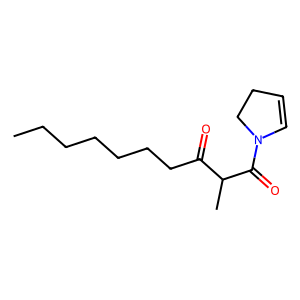

In [ ]:
from hme.data import HMEDataset
# --- Load Demo Data ---
TEST_DATA_JSON_PATH='../datasets/general_qa_test.json'
MOL_EMBEDDINGS_PT_PATH='../datasets/pubchem_train_test.json.cfm.pt'
print("\n--- Loading Demo Data Sample ---")

# We specify the task_type and data_type required by this sample
demo_dataset = HMEDataset(
    data_path=TEST_DATA_JSON_PATH,
    task_type='qa',
    data_type='1d,2d,3d,frg',  ##we use 1D,2D,3D,Fragment features as the multi-modal inputs
    emb_dict_mol=MOL_EMBEDDINGS_PT_PATH,
    emb_dict_protein='none'
)


# This returns a list: [question, answer, 2d_features, 3d_features, protein_features]
data_sample = demo_dataset[21]
prompt_template, ground_truth_answer, mol_2d_features, mol_3d_features, _ = data_sample

# Prepare features for inference (add batch dimension and move to device)
mol_2d_features = mol_2d_features.unsqueeze(0).to(DEVICE)
mol_3d_features = mol_3d_features.unsqueeze(0).to(DEVICE)

# Get the SMILES string for visualization
smiles_for_demo = demo_dataset.json_list[21]['smiles']
mol_for_demo = Chem.MolFromSmiles(smiles_for_demo)

print("Successfully loaded one sample for demonstration.")
print(f"Molecule SMILES: {smiles_for_demo}")
print(f"2D Features Shape: {mol_2d_features.shape}")
print(f"3D Features Shape: {mol_3d_features.shape}")
print(f"Question:{demo_dataset.json_list[21]['instruction']}")
Draw.MolToImage(mol_for_demo)

Run the model, perform inference, and display the model's answer and Groud Truth.

If you want to get the full results on the test set, run our bash script in ./scripts/eval_general-qa.sh

In [11]:
# The prompt comes directly from our loaded data sample
prompt_multi_modal = prompt_template
# Use the HMEProcessor to correctly combine text and modal features
inputs_multi_modal = processor(
    text=prompt_multi_modal,
    molecule_raw_2d_features=mol_2d_features,
    molecule_raw_3d_features=mol_3d_features,
    return_tensors="pt"
)

inputs_multi_modal = {
    k: v.to(DEVICE) if isinstance(v, torch.Tensor) else v
    for k, v in inputs_multi_modal.items()
}

# Generate a response
with torch.no_grad():
    output_ids_mm = model.generate(
        **inputs_multi_modal,
        max_new_tokens=100,
        do_sample=False,
        eos_token_id=tokenizer.eos_token_id,
    )

# Decode and print the response
response_ids_mm = output_ids_mm[:, inputs_multi_modal['input_ids'].shape[1]:]
response_text_mm = tokenizer.batch_decode(response_ids_mm, skip_special_tokens=True)[0]

print("--- Multi-Modal Prompt ---")
print(prompt_multi_modal)
print("\n--- Ground Truth Answer ---")
print(ground_truth_answer)
print("\n--- Model Response ---")
print(response_text_mm)

We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


--- Multi-Modal Prompt ---
What class does this molecule belong to? Molecular 2D features are: <molecule_2d><molecule_2d><molecule_2d><molecule_2d><molecule_2d><molecule_2d><molecule_2d><molecule_2d>. Molecular 3D features are: <molecule_3d><molecule_3d><molecule_3d><molecule_3d><molecule_3d><molecule_3d><molecule_3d><molecule_3d><molecule_3d><molecule_3d><molecule_3d><molecule_3d><molecule_3d><molecule_3d><molecule_3d><molecule_3d>. Molecular SMILES is: CCCCCCCC(=O)C(C)C(=O)N1C=CCC1. Molecular fragments are: <|CCC(=O)NC|><|CCCC=O|><|CCCC|><|CCC|>.

--- Ground Truth Answer ---
This molecule belongs to the class of pyrroles.

--- Model Response ---
 This molecule belongs to the class of pyrroles.


-----------------------------

Afterwards, we show the model's performance on the **Description-based Molecular Generation** task. For this task, molecular 2D and 3D features are not involved, so there is no need to load feature_fuser.

Load the model. (You can restart this notebook before running the cell below to prevent memory overflow caused by the previous model still occupying GPU memory.)

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from rdkit import Chem
from rdkit.Chem import Draw

# Import the custom classes from our package
from hme.modeling_llava import (
    HMEForConditionalGeneration,
    HMEForSequenceRegression,
    HMEForSequenceClassification,
    HMEConfig,
)
from hme.data import HMEProcessor,TrainHMECollator

# --- Configuration ---
MODEL_PATH = "../checkpoints/HME_description-based-molecular-generation_merged"
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

# --- Load Model Components ---
# 1. Load the base language model and tokenizer
language_model = AutoModelForCausalLM.from_pretrained(MODEL_PATH,torch_dtype=torch.bfloat16,attn_implementation="flash_attention_2").to(DEVICE)
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
tokenizer.padding_side = "left" # Important for generation

# 2. Create the full HME model architecture
config=HMEConfig(text_config=language_model.config,
                    molecule_2d_hidden_size=300,
                    molecule_3d_hidden_size=512,
                    protein_hidden_size=128,
                    ignore_index=-100,
                    modal_padding=-100,
                    projector_hidden_act="gelu",
                    protein_token_index=tokenizer.convert_tokens_to_ids("<protein>"),
                    molecule_2d_token_index=tokenizer.convert_tokens_to_ids("<molecule_2d>"),
                    molecule_3d_token_index=tokenizer.convert_tokens_to_ids("<molecule_3d>"),
        )
model = HMEForConditionalGeneration(config, language_model)

model.to(DEVICE).eval().to(torch.bfloat16)

# 3. Create the HME Processor, Collator
processor = HMEProcessor(tokenizer=tokenizer, max_length=512)
data_collator = TrainHMECollator(processor=processor, config=config)

print(f"Model and tokenizer loaded successfully on {DEVICE}.")

You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Model and tokenizer loaded successfully on cuda:0.


Load the dataset used for demonstration. Here we directly load the test set and use one sample as demonstration.


In [ ]:
from hme.data import HMEDataset
# --- Load Demo Data ---
TEST_DATA_JSON_PATH='../datasets/desc2mol_test.json'
print("\n--- Loading Demo Data Sample ---")
# We specify the task_type and data_type required by this sample
demo_dataset = HMEDataset(
    data_path=TEST_DATA_JSON_PATH,
    task_type='text2frgsmi',
    data_type='1d,frg',  ##we use 1D,2D,3D,Fragment features as the multi-modal inputs
    emb_dict_mol='none',
    emb_dict_protein='none'
)


# This returns a list: [question, answer, 2d_features, 3d_features, protein_features]
# For this task, 2D and 3D features are not needed.
data_sample = demo_dataset[2906]
prompt_template, ground_truth_answer, _,_ , _ = data_sample


# Get the description for visualization
description_for_demo = demo_dataset.json_list[2906]['description']

print("Successfully loaded one sample for demonstration.")
print(f"Description: {description_for_demo}")


--- Loading Demo Data Sample ---
Successfully loaded one sample for demonstration.
Description: The molecule is a N-arylpiperazine that is piperazine carrying a 3-chlorophenyl substituent at position 1. It is a metabolite of the antidepressant drug trazodone. It has a role as a drug metabolite, a serotonergic agonist, an environmental contaminant and a xenobiotic. It is a N-arylpiperazine and a member of monochlorobenzenes.


The model performs inference using the Chain-of-Fragment (CoF) mechanism, meaning it generates corresponding fragments and then the complete molecule based on the descriptive text.

If you want to get the full results on the test set, run our bash script in ./scripts/eval_description-based-mol-gen.sh

We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


--- Multi-Modal Prompt ---
Please give me molecular fragments based on the description. And then give me the molecular SMILES based on both the fragments and the description. The description is: The molecule is a N-arylpiperazine that is piperazine carrying a 3-chlorophenyl substituent at position 1. It is a metabolite of the antidepressant drug trazodone. It has a role as a drug metabolite, a serotonergic agonist, an environmental contaminant and a xenobiotic. It is a N-arylpiperazine and a member of monochlorobenzenes.

--- Ground Truth Answer ---
Molecular fragments are: <|C1CNCCN1|><|Clc1ccccc1|> Molecular SMILES is: Clc1cccc(N2CCNCC2)c1

--- Model Response ---
 Molecular fragments are: <|C1CNCCN1|><|Clc1ccccc1|> Molecular SMILES is: Clc1cccc(N2CCNCC2)c1


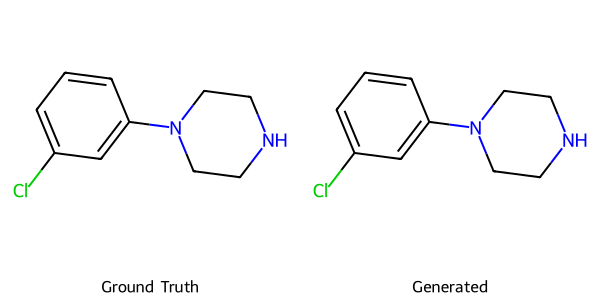

In [ ]:
# The prompt comes directly from our loaded data sample
prompt_multi_modal = prompt_template
# Use the HMEProcessor to correctly combine text and modal features
inputs_multi_modal = processor(
    text=prompt_multi_modal,
    return_tensors="pt"
)

inputs_multi_modal = {
    k: v.to(DEVICE) if isinstance(v, torch.Tensor) else v
    for k, v in inputs_multi_modal.items()
}

# Generate a response
with torch.no_grad():
    output_ids_mm = model.generate(
        **inputs_multi_modal,
        max_new_tokens=512,
        do_sample=True,
        eos_token_id=tokenizer.eos_token_id,
    )

# Decode and print the response
response_ids_mm = output_ids_mm[:, inputs_multi_modal['input_ids'].shape[1]:]
response_text_mm = tokenizer.batch_decode(response_ids_mm, skip_special_tokens=True)[0]

print("--- Multi-Modal Prompt ---")
print(prompt_multi_modal)
print("\n--- Ground Truth Answer ---")
print(ground_truth_answer)
print("\n--- Model Response ---")
print(response_text_mm)

print("The generated molecule is visualized below:")
from rdkit import Chem
from rdkit.Chem import Draw

gt_smiles = ground_truth_answer.split('SMILES is: ')[-1].strip()
gen_smiles = response_text_mm.split('SMILES is: ')[-1].strip()

mols = [Chem.MolFromSmiles(gt_smiles), Chem.MolFromSmiles(gen_smiles)]
img = Draw.MolsToGridImage(mols, molsPerRow=2, subImgSize=(300,300), legends=["Ground Truth", "Generated"])
img

**Multi-Fragment-Conditional Molecule Generation**: the following code illustrates how the generated molecule is broken down into fragments.

The generated SMILES contains the following 2 fragments: <|Clc1ccccc1|><|C1CNCCN1|>
The fragmented molecule is visualized below:


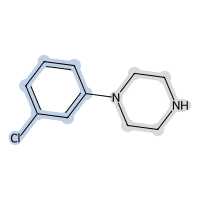

In [ ]:
from hme.frg import get_frg_from_one_smiles
from hme.psvae.mol_bpe import Tokenizer
from IPython.display import SVG

fragments,_,fragmented_mol=get_frg_from_one_smiles(gen_smiles,vocab_file='../src/hme/fragment_vocabs/vocab_800_other_tasks.txt',verbose=True)
print(f'The generated SMILES contains the following {len(fragments.split("><"))} fragments: {fragments}')

print('The fragmented molecule is visualized below:')
SVG(fragmented_mol[0].to_SVG())